In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics
from dataloader.animal_faces import AnimalfaceDataset

%reload_ext autoreload
%autoreload 2

/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [39]:
width = 128
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
# train_transform = transforms.Compose([transforms.ToTensor()])

In [40]:
train_data = AnimalfaceDataset(transform=train_transform, img_width=width)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 14630/14630 [04:04<00:00, 59.90it/s]


In [41]:
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
val_data = AnimalfaceDataset(transform=val_transform, type="val", img_width=width)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:09<00:00, 158.55it/s]


In [42]:
def show_img(x):
    plt.figure(figsize=(2,2))
    plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

torch.Size([512, 3, 128, 128]) torch.Size([512])


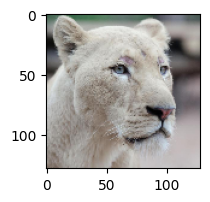

In [43]:
BATCH_SIZE = 512
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(val_loader))
print(x.shape, y.shape)
show_img(x)

In [211]:
from models.auto_encoder import AutoEncoder, Encoder, Decoder
%reload_ext autoreload
%autoreload 2

In [212]:
# conv_ip_size = (128, 6, 6)
# feature_size = 2048 
# filters = [3,12,24,48,128]
# kernel_sizes = [7, 5, 3, 3]
# strides = [2, 2, 2, 2]
# output_paddings = [1,0,0,1]
# paddings = [0,0,0,0]


# feature_size = 128 
# filters = [3, 16, 32]
# kernel_sizes = [7,5]
# strides = [2,2]
# output_paddings = [0,1]
# paddings = [0,0]
# return_only_liner = 0
# dropout_prob = 0.05

# feature_size = 20 
# filters = [3, 32, 32, 64, 64, 256]
# kernel_sizes = [4, 4, 4, 4, 4]
# strides = [2,2,2,2,1]
# paddings = [1,1,1,1,0]
# output_paddings = [0,0,0,0,0]
# # paddings = [0,0]
# return_only_liner = 0
# dropout_prob = 0.05



feature_size = 128
filters = [3, 16, 32, 64, 128, 256]
kernel_sizes = [4, 4, 4, 4, 4]
strides = [2,2,2,2,2]
paddings = [0,0,0,0,0]
output_paddings = [0,1,0,0,0]
# paddings = [0,0]
return_only_liner = 0
dropout_prob = 0.0


# Puspak - 64
# feature_size = 32
# filters = [3, 32, 64, 128, 256]
# kernel_sizes = [4, 4, 4, 4]
# strides = [2,2,2,2]
# paddings = [0,0,0,0]
# output_paddings = [0,1,0,0]
# # paddings = [0,0]
# return_only_liner = 0
# dropout_prob = 0.0

if return_only_liner:
    conv_ip_size = (3, 128, 128)
    hidden_sizes = [128*128*3, 4096, feature_size]
else:
    conv_ip_size = (256,2,2)
#     hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], 256*3, 256, feature_size]
    hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], feature_size]    

In [213]:
e = Encoder(filters=filters, 
            kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hidden_sizes, 
            return_only_liner=return_only_liner, return_only_conv=0, paddings=paddings)
op = e(x)
print(op.shape)
# summary(e, (3,64,64), device="cpu")
summary(e, (3,width,width), device="cpu")

torch.Size([512, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 63, 63]             784
              ReLU-2           [-1, 16, 63, 63]               0
            Conv2d-3           [-1, 32, 30, 30]           8,224
              ReLU-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 14, 14]          32,832
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7            [-1, 128, 6, 6]         131,200
              ReLU-8            [-1, 128, 6, 6]               0
            Conv2d-9            [-1, 256, 2, 2]         524,544
             ReLU-10            [-1, 256, 2, 2]               0
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 128]         131,200
Total params: 828,784
Trainable params: 828,784
Non-trainable params: 0
--------

In [214]:
# d = Decoder(conv_op_size=conv_ip_size, filters=filters[::-1], 
#                                kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings[::-1],
#                                  paddings=paddings[::-1], hiddens_sizes=hidden_sizes[::-1] , return_only_conv=True)
# do = d(op.flatten(start_dim=1))
# print("hello-",do.shape)
# # summary(d, (feature_size,), device="cpu")
# summary(d, op.flatten(start_dim=1).shape, device="cpu")

In [215]:
ae = AutoEncoder(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, droput_prob=dropout_prob).to(device)
op, enc = ae(x.to(device))
print(op.shape, enc.shape)

# summary(ae, (3,32,32), device="cuda")
summary(ae, (3,width,width), device="cuda")

[128, 1024]
torch.Size([512, 3, 128, 128]) torch.Size([512, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 63, 63]             784
              ReLU-2           [-1, 16, 63, 63]               0
            Conv2d-3           [-1, 32, 30, 30]           8,224
              ReLU-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 14, 14]          32,832
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7            [-1, 128, 6, 6]         131,200
              ReLU-8            [-1, 128, 6, 6]               0
            Conv2d-9            [-1, 256, 2, 2]         524,544
             ReLU-10            [-1, 256, 2, 2]               0
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 128]         131,200
          Encoder-13                 

In [ ]:
%%time
n_epochs = 100
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=1e-3)
losses = []
val_losses = []
for epoch in range(n_epochs):
    ae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc = ae(X) # [B, feature_size]
        loss = loss_fn(X, X_hat)
        loss.backward()
        optim.step()

        tqdm_obj.set_description_str(f"Epoch: {epoch} Loss {loss}")
        if i%1 == 0:
            losses.append(loss.detach().to(cpu_device))
    
    with torch.no_grad(): # mandatory to write
        ae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc = ae(X) # [B, feature_size]
            val_loss = loss_fn(X, X_hat)

            tqdm_obj.set_description_str(f"Epoch {epoch} Val Loss {val_loss}")
            if i%1 == 0:
                val_losses.append(val_loss.detach().to(cpu_device))
                

Epoch: 75 Loss 0.01745540276169777:  34%|██▍    | 10/29 [00:00<00:01, 10.19it/s]

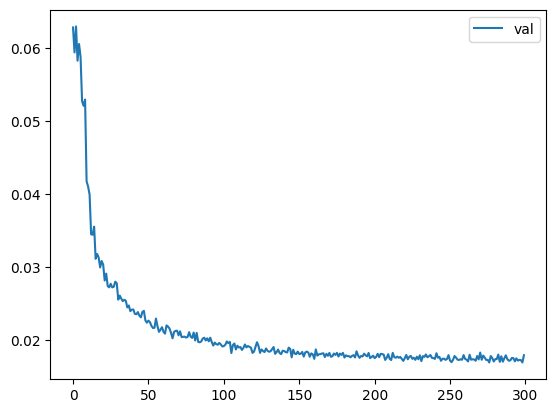

In [207]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
# plt.plot(to_cpu(losses), label="train")
plt.plot(to_cpu(val_losses)[0:], label="val")
plt.legend()

In [208]:
from torchvision.utils import save_image, make_grid
# Generation
grid_size = 10
# z = torch.rand(grid_size*grid_size, Z_DIM)
x_hat, enc = ae(x.to(device))
# print(x_hat.shape) # ----> .Size([1, 3, 128, 128])
# x_hat = x_hat.squeeze() # necessary for printing image
generated_grid = make_grid(x_hat, nrow=grid_size)
save_image(generated_grid,f"generated_{feature_size}_1l.png")
# generated_grid

In [ ]:
torch.save(ae.state_dict(), f"ckpts/autoencoder_{feature_size}_1l.pt")

In [160]:
x, y = next(iter(val_loader))

torch.Size([512, 3, 128, 128])

<Figure size 640x480 with 0 Axes>

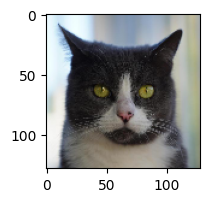

<Figure size 640x480 with 0 Axes>

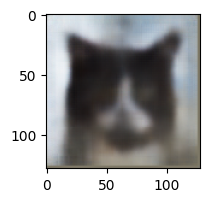

In [209]:
x, y = next(iter(val_loader))
with torch.no_grad():
    ae.eval()
    x_hat, enc = ae(x.to(device))
plt.figure()
show_img(x)
plt.figure()
show_img(x_hat)

### Observations
Effect of kernels size: 
Keep all constant (3)

effect of latent dim:
Try: 2048, 128X6X6

effect of number of filters: Looks like val loss decreasing if we increase number of filters

In [119]:
feature_size

2048

In [210]:
torch.save(ae.state_dict(), f"ckpts/autoencoder_{feature_size}_1l.pt")